# Pentapeptide showcase with PyEMMA

This notebook now mirrors the **00 - Showcase pentapeptide** walkthrough from the [PyEMMA Learn portal](http://www.emma-project.org/devel/generated/00-pentapeptide-showcase.html). We keep the steps minimal, load the official mdshare dataset, compare backbone featurizations with VAMP2, project into TICA, cluster the slow degrees of freedom, estimate and validate MSMs, visualize MSM spectra, and inspect PCCA/TPT results together with simple experimental observables. All data references follow the `COURSE_DIR/data` convention used across the course. 


## Table of contents

- [Step 1](#step-1)
- [Data input and featurization](#data-input-and-featurization)
- [Step 3](#step-3)
- [Feature ranking with VAMP2](#feature-ranking-with-vamp2)
- [Coordinate transform: TICA](#coordinate-transform-tica)
- [Discretization via clustering](#discretization-via-clustering)
- [MSM estimation & validation](#msm-estimation-validation)
- [Step 8](#step-8)
- [Spectral analysis & PCCA/TPT](#spectral-analysis-pccatpt)
- [Step 10](#step-10)
- [Step 11](#step-11)
- [Experimental observables and PCCA samples](#experimental-observables-and-pcca-samples)


## Step 1

Grab the pentapeptide PDB and all 25 implicit-solvent trajectories via `mdshare.fetch` so we can try the original walkthrough’s data pipeline.


In [9]:
from pathlib import Path
import os

from contextlib import nullcontext
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma

COURSE_DIR = Path(os.environ.get('COURSE_DIR', str(Path.home() / 'Concepcion26'))).expanduser()
DATA_DIR = COURSE_DIR / 'data'
DATA_DIR.mkdir(parents=True, exist_ok=True)

## Data input and featurization

The tutorial loads a pentapeptide PDB and 25 trajectories (implicit solvent, 0.1 ns timestep) via `mdshare.fetch` and compares several backbone featurizations. We mimic that flow here.


In [10]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory=str(DATA_DIR))
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory=str(DATA_DIR))
print('Topology:', pdb)
print('Trajectories:', len(files))

Topology: /home/jordivilla/Concepcion26/data/pentapeptide-impl-solv.pdb
Trajectories: 25


## Step 3

Now we compare the backbone torsions, positions, and distances using cross-validated VAMP2 scores to see which feature set keeps the most kinetic variance before moving on to dimensionality reduction.


In [11]:
torsions_feat = pyemma.coordinates.featurizer(str(pdb))
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)

positions_feat = pyemma.coordinates.featurizer(str(pdb))
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)

backbone = torsions_feat.select_Backbone()
distances_feat = pyemma.coordinates.featurizer(str(pdb))
distances_feat.add_distances(distances_feat.pairs(backbone, excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)


100%|██████████| 25/25 [00:00<00:00, 29.37it/s]                                 


## Feature ranking with VAMP2

We compute cross-validated VAMP2 scores for the torsions, position, and distance featurizations at several lag times to identify the most kinetically informative descriptors.


/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extra

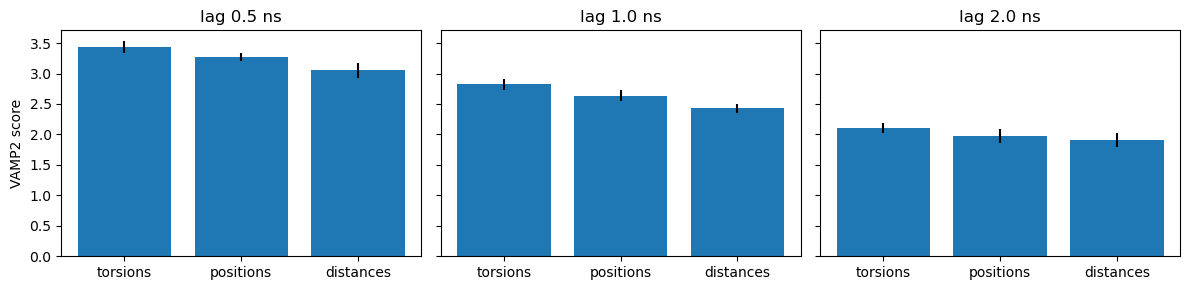

In [12]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    contexts = getattr(pyemma.util, 'contexts', None)
    if contexts is None:
        ctx = nullcontext()
    else:
        ctx = contexts.settings(show_progress_bars=False)
    with ctx:
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp([
                d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

labels = ['torsions', 'positions', 'distances']

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    data_scores = []
    data_errors = []
    for dataset in (torsions_data, positions_data, distances_data):
        sc = score_cv(dataset, dim=10, lag=lag)
        data_scores.append(sc.mean())
        data_errors.append(sc.std())
    ax.bar(labels, data_scores, yerr=data_errors)
    ax.set_title(f'lag {lag * 0.1:.1f} ns')
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

VAMP2 revealed backbone torsions as slightly superior, so we continue with those coordinates.


## Coordinate transform: TICA


/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


100%|██████████| 25/25 [00:00<00:00, 995.26it/s]              


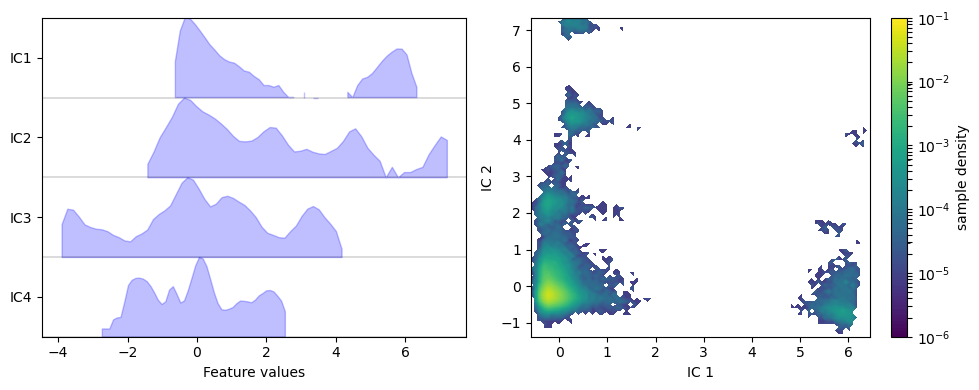

In [13]:
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[0], feature_labels=[f'IC{i+1}' for i in range(4)], ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

## Discretization via clustering


/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/tmp/ipykernel_15781/1125788638.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores[idx, trial] = msm.score_cv(cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_Depreca

16-01-26 07:52:09 pyemma.coordinates.clustering.kmeans.KmeansClustering[1275] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/tmp/ipykernel_15781/1125788638.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores[idx, trial] = msm.score_cv(cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/jordivi

16-01-26 07:52:29 pyemma.coordinates.clustering.kmeans.KmeansClustering[1339] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.



/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|██████████| 25/25 [00:00<00:00, 338.79it/s]                          


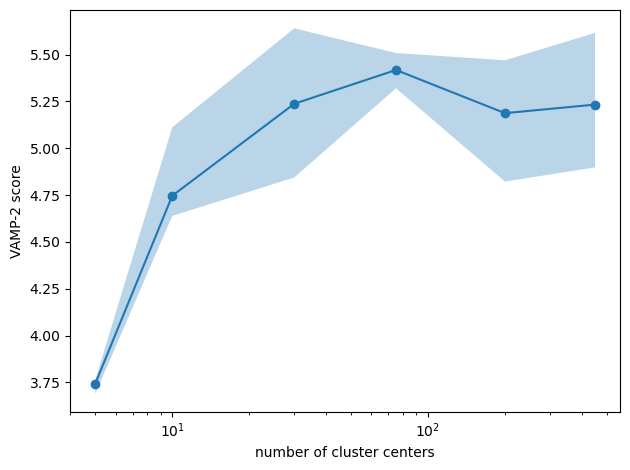

In [14]:
ncenters = [5, 10, 30, 75, 200, 450]
scores = np.zeros((len(ncenters), 5))
contexts = getattr(pyemma.util, 'contexts', None)
for idx, k in enumerate(ncenters):
    for trial in range(5):
        ctx = contexts.settings(show_progress_bars=False) if contexts else nullcontext()
        with ctx:
            cl = pyemma.coordinates.cluster_kmeans(tica_output, k=k, max_iter=50, stride=50)
            msm = pyemma.msm.estimate_markov_model(cl.dtrajs, 5)
            scores[idx, trial] = msm.score_cv(cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(ncenters, lower, upper, alpha=0.3)
ax.plot(ncenters, scores.mean(axis=1), '-o')
ax.set_xscale('log')
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

k = 75
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=k, max_iter=50, stride=10, fixed_seed=1)
dtrajs = np.concatenate(cluster.dtrajs)


## MSM estimation & validation


100%|██████████| 100/100 [00:00<00:00, 212.00it/s]                                                                    


fraction of states used: 1.0
fraction of counts used: 1.0


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]                        


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

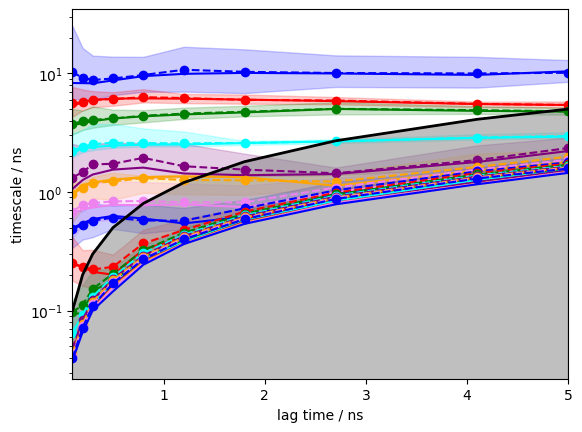

In [15]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='0.1 ns')
print('fraction of states used:', msm.active_state_fraction)
print('fraction of counts used:', msm.active_count_fraction)
its = pyemma.msm.its(cluster.dtrajs, lags=50, nits=15, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1)


## Step 8

After exploring the MSM diagnostics, we pause to collect the spectral analysis, PCCA memberships, and TPT targets that make the pentapeptide story interpretable before sampling states.


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]                        


(<Figure size 1000x1000 with 25 Axes>,
 array([[<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='lag time (ns)', ylabel='probability'>,
         <AxesSubplot:xlabel='lag time (ns)'>,
         <AxesSubplot:xlabel='lag time (ns)'>,
         <AxesSubplot:xlabel='lag time (ns)'>,
         <AxesSubplot:xlabel='lag time (ns)'>]], dtype=object))

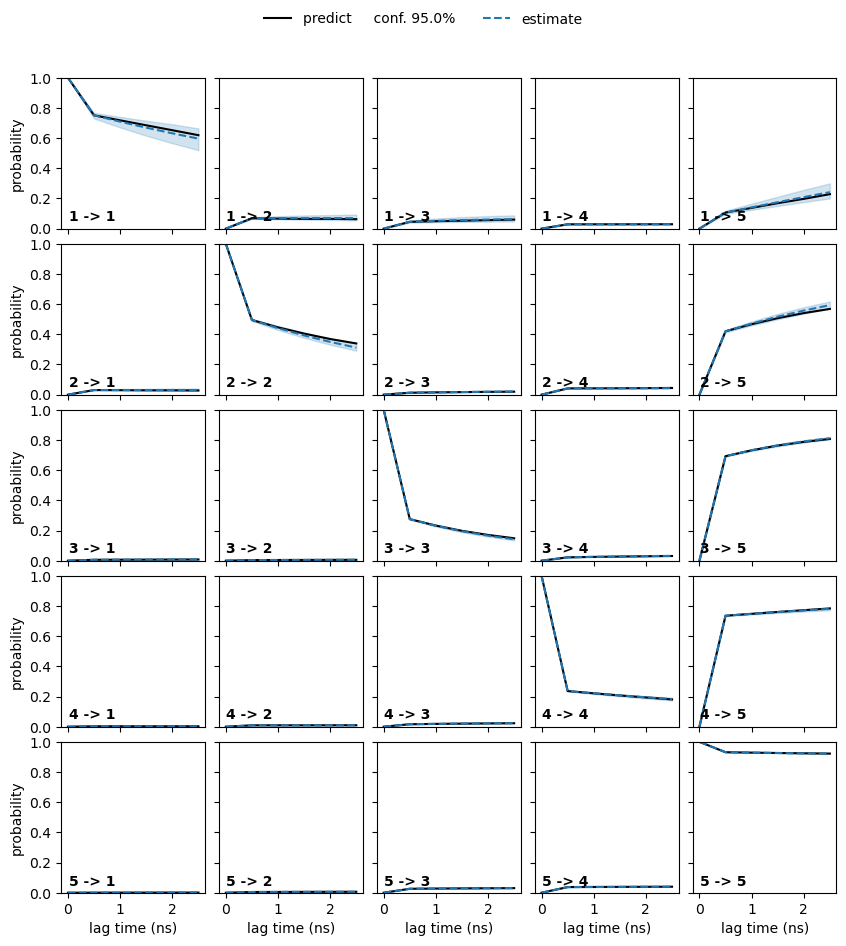

In [16]:
nstates = 5
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns')

### Chapman–Kolmogorov result

The CK plot overlays the directly estimated transition probabilities at lag multiples with the predictions from raising the lag-5 matrix to the corresponding power. The close overlap for all five metastable sets indicates that our lag time is already long enough for memory to decay, so the MSM propagations remain consistent and we can trust the implied timescales derived at τ=5 steps.


## Spectral analysis & PCCA/TPT


Text(0, 0.5, 'IC 2')

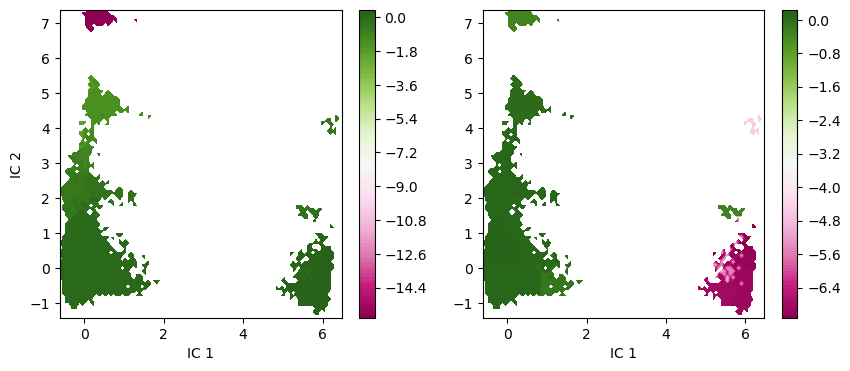

In [17]:
eigvec = msm.eigenvectors_right()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, eigvec[dtrajs, 1], ax=axes[0], cmap='PiYG', mask=True)
pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, eigvec[dtrajs, 2], ax=axes[1], cmap='PiYG', mask=True)
[ax.set_xlabel('IC 1') for ax in axes];
axes[0].set_ylabel('IC 2')

## Step 10

With metastable states in hand, we build experimental observables (SASA, radius of gyration, Trp-1 signals) so you can link the MSM to measurable quantities and non-equilibrium relaxations.


Text(0, 0.5, 'IC 2')

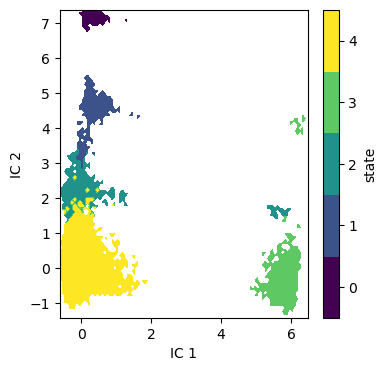

In [18]:
pcca = msm.pcca(nstates)
metatraj = msm.metastable_assignments[dtrajs]
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_state_map(*tica_concatenated[:, :2].T, metatraj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')


## Step 11


### Transition path theory results

We compute the committor between two metastable macrostates of interest and inspect the reactive fluxes that carry the net probability current. The resulting TPT objects transform the MSM into pathway-level information that helps us trace exactly how the pentapeptide transitions between macrostates.


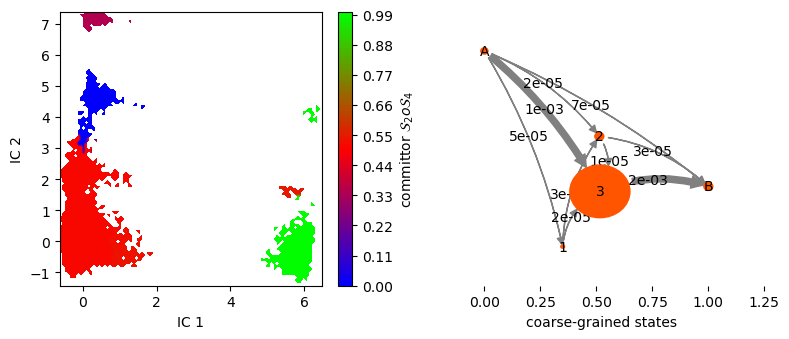

In [21]:
start, final = 1, 3
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)
cg, cgflux = flux.coarse_grain(msm.metastable_sets)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    flux.committor[dtrajs],
    ax=ax1,
    mask=True,
    cmap="brg",
    cbar_label="committor $\mathcal{S}_2 \to \mathcal{S}_4$")
ax1.set_xlabel("IC 1")
ax1.set_ylabel("IC 2")
pyemma.plots.plot_flux(
    cgflux,
    ax=ax2,
    show_committor=True,
    max_width=15,
    max_height=15,
    minflux=1e-5)
ax2.set_yticks([])
ax2.set_xlabel("coarse-grained states")
fig.tight_layout()


#### About this TPT cell

We chose macrostates `A` (S_2) and `B` (S_4) because they represent the main entry and exit basins along the slowest pathway. The `pyemma.msm.tpt` call builds the committor `q`, and `flux.coarse_grain` collapses the Bayesian sample to the PCCA macrostates. The contour plot shows how `q` varies across the TICA plane, and the flux diagram visualizes the net currents that actually carry probability between the macrostates, highlighting the preferred transition tube.


The committor highlights where the slow transition tube is located inside the TICA embedding, while the coarse-grained flux plot shows the net probability current that flows from the chosen reactant to product states. Together these plots illustrate how TPT uses the MSM to map reactive pathways and guide the selection of states for downstream observables.


## Experimental observables and PCCA samples


In [22]:
from itertools import product
from mdtraj import shrake_rupley, compute_rg

markov_samples = [smpl for smpl in msm.sample_by_state(20)]
reader = pyemma.coordinates.source(files, top=str(pdb))
samples = [pyemma.coordinates.save_traj(reader, sample, outfile=None, top=str(pdb)) for sample in markov_samples]
markov_sasa = [shrake_rupley(sample, mode='residue') for sample in samples]
markov_rg = [compute_rg(sample) for sample in samples]
markov_average_rg = np.array(markov_rg).mean(axis=1)
print('Average Rg (nm):', msm.expectation(markov_average_rg))

100%|██████████| 25/25 [00:00<00:00, 479.42it/s]           


Average Rg (nm): 0.4956876120358281


To finish, follow the remaining PyEMMA notebooks if you want deeper practice with MSM analysis, PCCA/TPT, and HMMs, just like the original showcase links do.
